# Computer Vision - Segmentation

 ![](https://camo.githubusercontent.com/0bff1f2d32ebee5d9e806dc83e6b124f64ebe16ab9d86ced625041799ee26017/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67)
 
В данном задании предлагается научиться решать задачу сегментации. 
Используемый набор данных COCOStuff10k:
https://github.com/nightrome/cocostuff10k

Данный набор данных - подмножество набора COCOStuff, который в свою очередь является подмножеством набора COCO.

Задание будет оцениваться в 20 баллов.
10 баллов - за Computer Vision часть, 10 баллов - за структуру проекта (вы же сделали framework?), дополнительные фишки

## Computer Vision
Данная часть состоит из программирования и экспериментов.   
Какого-то конкретного baseline не предлагается, качество модели - на вашей совести.
Разрешено использовать все, что есть в PyTorch (torch.nn, torch.utils.data и т.д.).

Предполагаемый ход работы:
1. Реализовать Dataset и Dataloader для датасета COCOStuff
2. Реализовать ResNet блок с bottleneck.
3. Реализовать MobileNet блок (с декомпозированной сверткой)
4. Используя реализованные блоки реализовать U-Net (можно использовать меньшее количество слоев) для сегментации.
5. Произвести обучение самописного U-Net, и вывести метрики качества (https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics/notebook) на тестовой выборке:
    * Dice Score
    * MSE
6. Запустить предобученную модель из torchvision или timm, аналогичную реализованной - собрать метрики качества.
7. Сделать выводы по проведенному эксперименту
    
## Структура проекта
Оценка здесь будет производиться несколько субъективно, однако, есть идея о том, что мы хотим увидеть:
1. Проект должен быть структурирован: с разными папками, модулями, импортами.
2. Отдельные скрипты (Notebook) для обучения и инференса.
3. Загрузка данных производится через Dataloader.

Вы можете производить **любые** манипуляции с данными:
1. Если слишком большие картинки - выполнить CenterCrop
2. Аугментации (если умеете, необязательно)

Манипуляции с данными не являются обязательными для реализации.


# Работа с данными

In [ ]:
import pickle
import numpy as np
import torch
import string
import random

from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from matplotlib import colors, pyplot as plt

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn

import os.path
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#размер батча
batch_size = 6
# разные режимы датасета 
DATA_MODES = ['train', 'test']
# размер картинок 224х224 
RESCALE_SIZE = 300
# работаем на видеокарте
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Загрузим датасет COCOstuff10k

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#!cp '/content/gdrive/My Drive/ABBYY Homeworks/cocostuff-10k-v1.1.json' cocostuff-10k-v1.1.json
!unzip -q /content/gdrive/My\ Drive/ABBYY\ Homeworks/cocostuff-10k-v1.1.zip

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [ ]:
import scipy.io
mat = scipy.io.loadmat('annotations/COCO_train2014_000000000077.mat')

In [ ]:
NUM_CLASSES = len(mat['names']) + 1

print(len(mat['names']))

182


In [ ]:
img = cv.cvtColor(cv.imread('images/COCO_train2014_000000000077.jpg'), cv.COLOR_BGR2RGB)

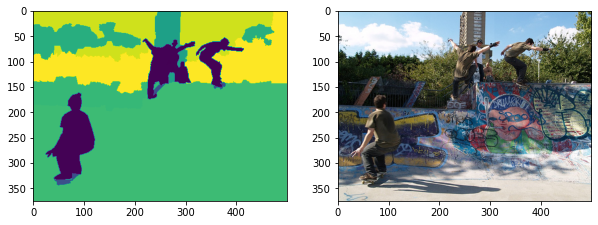

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(mat['S'])
axes[1].imshow(img)

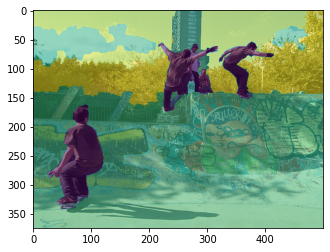

In [ ]:
plt.imshow(img)
plt.imshow(mat['S'], alpha=0.5)

In [ ]:
train_files = []
with open("./imageLists/train.txt","r") as f:
    data = f.read()
    
for el in data.split("\n")[:-1]:
    tokens = el.split(".")
    image_id = tokens[0]
    train_files.append(image_id)

In [ ]:
train_files[0]

'COCO_train2014_000000000077'

In [ ]:
test_files = []
with open("./imageLists/test.txt","r") as f:
    data = f.read()
    
for el in data.split("\n")[:-1]:
    tokens = el.split(".")
    image_id = tokens[0]
    test_files.append(image_id)

In [ ]:
test_files[0]

'COCO_train2014_000000000825'

In [ ]:
transform_mat = transforms.Compose([
    transforms.CenterCrop(RESCALE_SIZE),
    #transforms.Resize((51,51))
])

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(RESCALE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Создадим класс Dataset для изображений

In [ ]:
class TopchickDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()

        self.imgs = files
         
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.imgs)
                      
    def __len__(self):
        return self.len_

    def load_sample(self, file):

        mat = scipy.io.loadmat("./annotations/{}.mat".format(file))

        img = Image.open('./images/{}.jpg'.format(file)).convert('RGB')
        img.load()

        return mat, img
  
    def __getitem__(self, index):

        mats, images = self.load_sample(self.imgs[index])
        mats = torch.LongTensor(mats['S'])
          
        images = transform(images)
        mats = transform_mat(mats.unsqueeze(0)).squeeze()

        return images, mats

Сразу определим для train и test свой Dataset и Dataloader

In [ ]:
train_dataset = TopchickDataset(files=train_files[:1000], mode='train')
test_dataset = TopchickDataset(files=test_files[:100], mode='test')

In [ ]:
print(len(train_dataset), len(test_dataset))

1000 100


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
train_dataset[10][1].size()

torch.Size([300, 300])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


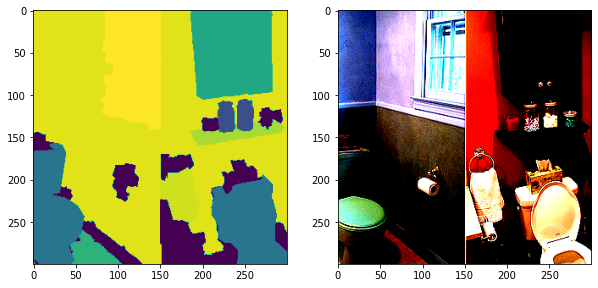

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(train_dataset[10][1])
axes[1].imshow(train_dataset[10][0].permute(1,2,0))

# Модель

Здесь будет реализовано две версии для нейросети U-Net: используя ResNet и MobileNet блоки

**ResNet block:**

In [ ]:
def conv_layer(chann_in, chann_out, kernel_size=3, padding_size=0, padding_mode='zeros', stride=1):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size, 
                  padding=padding_size, padding_mode=padding_mode, stride=stride),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

In [ ]:
class ResNetBottleNeckBlock(nn.Module):
    def __init__(self, chann_in, chann_out, kernel_size=3, padding_size=0, padding_mode='zeros', expansion = 1, stride=1):
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(chann_in, chann_out, kernel_size=1, 
                      padding=0, padding_mode=padding_mode, stride=stride),
            nn.BatchNorm2d(chann_out),
            nn.ReLU()
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(chann_out, chann_out, kernel_size=kernel_size, 
                      padding=padding_size, padding_mode=padding_mode, stride=stride),
            nn.BatchNorm2d(chann_out),
            nn.ReLU()
        )

        self.layer_3 = nn.Sequential(
            nn.Conv2d(chann_out, chann_out*expansion, kernel_size=1, 
                      padding=0, padding_mode=padding_mode, stride=stride),
            nn.BatchNorm2d(chann_out*expansion),
            nn.ReLU()
        )

        self.shortcut = nn.Sequential(
            nn.Conv2d(chann_in, chann_out*expansion, kernel_size=kernel_size, 
                      padding=padding_size, padding_mode=padding_mode, stride=stride),
            nn.BatchNorm2d(chann_out*expansion),
            nn.ReLU()
        )
        
    def forward(self, x):
        residial = self.shortcut(x)

        output = self.layer_1(x)
        output = self.layer_2(output)
        output = self.layer_3(output)
        output = output + residial

        return output

In [ ]:
dummy = torch.ones((1, 32, 224, 224))

block = ResNetBottleNeckBlock(32, 64, 3, 1,'reflect', 1)
block(dummy).shape

torch.Size([1, 64, 224, 224])

In [ ]:
class UNetWithResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = ResNetBottleNeckBlock(3, 16, 3, 1, 'reflect')
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)  # 3 -> 16

        self.enc_conv1 = ResNetBottleNeckBlock(16, 32, 3, 1, 'reflect')
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 16 -> 32

        self.enc_conv2 = ResNetBottleNeckBlock(32, 64, 3, 1, 'reflect')
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 32 -> 64

        self.enc_conv3 = ResNetBottleNeckBlock(64, 128, 3, 1, 'reflect')
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 64 -> 128

        # bottleneck
        self.bottleneck_conv = ResNetBottleNeckBlock(128, 128, 3, 1, 'reflect')  # 128 -> 128

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = ResNetBottleNeckBlock(256, 64, 3, 1, 'reflect')

        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = ResNetBottleNeckBlock(128, 32, 3, 1, 'reflect')

        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = ResNetBottleNeckBlock(64, 16, 3, 1, 'reflect')
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(32, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, NUM_CLASSES, kernel_size=3, 
                      padding=1, padding_mode='reflect', stride=1), # no activation
        )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x, i0 = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x, i1 = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x, i2 = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x, i3 = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(x, i3)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x, i2)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x, i1)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, i0)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)  # no activation

        return x

In [ ]:
dummy = torch.randn((1, 3, 224, 224))

block = UNetWithResNet()
block(dummy).shape

torch.Size([1, 183, 224, 224])

Аналогично реализуем U-Net с MobileNet блоками

**MobileNet:**

In [ ]:
class DepthWiseBlock(nn.Module):
    def __init__(self, chann_in, chann_out, kernel_size=3, padding_size=0, padding_mode='zeros', expansion = 1, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(chann_in, chann_in, kernel_size=kernel_size, 
                      padding=padding_size, padding_mode=padding_mode, stride=stride),
            nn.BatchNorm2d(chann_in),
            nn.ReLU()
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(chann_in, chann_out, kernel_size=1, 
                      padding=0, padding_mode=padding_mode, stride=stride),
            nn.BatchNorm2d(chann_out),
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [ ]:
dummy = torch.randn((1, 3, 224, 224))

block = DepthWiseBlock(3,16,3,1)
block(dummy).shape

torch.Size([1, 16, 224, 224])

In [ ]:
class UNetWithMobileNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = DepthWiseBlock(3, 16, 3, 1, 'reflect')
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)  # 3 -> 16

        self.enc_conv1 = DepthWiseBlock(16, 32, 3, 1, 'reflect')
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 16 -> 32

        self.enc_conv2 = DepthWiseBlock(32, 64, 3, 1, 'reflect')
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 32 -> 64

        self.enc_conv3 = DepthWiseBlock(64, 128, 3, 1, 'reflect')
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True) # 64 -> 128

        # bottleneck
        self.bottleneck_conv = DepthWiseBlock(128, 128, 3, 1, 'reflect')  # 128 -> 128

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = DepthWiseBlock(256, 64, 3, 1, 'reflect')

        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = DepthWiseBlock(128, 32, 3, 1, 'reflect')

        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = DepthWiseBlock(64, 16, 3, 1, 'reflect')
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv_layer(32, 16, 3, 1, 'reflect'),
            nn.Conv2d(16, NUM_CLASSES, kernel_size=3, 
                      padding=1, padding_mode='reflect', stride=1), # no activation
        )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x, i0 = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x, i1 = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x, i2 = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x, i3 = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(x, i3)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x, i2)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x, i1)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, i0)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)  # no activation

        return x

In [ ]:
dummy = torch.randn((1, 3, 224, 224))

block = UNetWithMobileNet()
block(dummy).shape

torch.Size([1, 183, 224, 224])

# Метрики качества

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{224 \times 224} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$


In [ ]:
def dice_coef(y_pred, y_true, smooth=1):

    y_pred = torch.argmax(y_pred, dim=1, keepdim=False)
    intersection = torch.sum(y_true * y_pred, dim=[1,2])
    union = torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2])
    return torch.mean( (2. * intersection + smooth) / (union + smooth), dim=0)

In [ ]:
def dice_loss(y_pred, y_true):
    return -dice_coef(y_pred, y_true)

**2. MSE loss:** стандартный квадрат разности между двумя масками $X$ и $Y$.


In [ ]:
def mse_loss(y_pred, y_real):
    y_pred = torch.argmax(y_pred, dim=1, keepdim=False)
    res = torch.sum((y_pred - y_real)**2)/y_pred.size()[0]/224/224
    return res 

# Цикл обучения

Предсказание результата:

In [ ]:
def plot_loss(losses):

    plt.plot(losses[0], label="train_loss")
    plt.plot(losses[1], label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid(which="both")

    plt.show()

Инференс загрузки и сохранения модели

In [ ]:
PATH_TO_PARENT = '/content/drive/MyDrive/ABBYY Homeworks'

def save_model(model, optim, name, epoch, losses):
    description = f"{model}\n\n{optim}"
    state = {
        'model_state': model.state_dict(),
        'optim_state': optim.state_dict(),
        'losses': losses,
        'epoch': epoch,
        'description': description
    }
    os.makedirs(f"{PATH_TO_PARENT}/saved", exist_ok=True)
    torch.save(state, f"{PATH_TO_PARENT}/saved/{name}.pth")

def load_model(model, optim, name, verbose=False):
    state = torch.load(f"{PATH_TO_PARENT}/saved/{name}.pth")
    description = state['description']
    if verbose:
        print('Loading model:')
        print(description)
    model.load_state_dict(state['model_state'])
    optim.load_state_dict(state['optim_state'])
    epoch = state['epoch']
    losses = state['losses']
    return epoch, losses

Вывод метрик:

In [ ]:
def test(model, data_val, loss_fn):
  avg_val_loss = 0
  model.eval()
  for X_batch, Y_batch in data_val:
      with torch.no_grad():
        # to device
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)

        # forward
        Y_pred = model(X_batch)

        val_loss = loss_fn(Y_pred, Y_batch) # forward-pass

        # calculate loss to show the user
        avg_val_loss += val_loss / len(data_val)
  return avg_val_loss.item()

Тренировочный цикл

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, name=""):
    X_val, Y_val = next(iter(data_val))
    losses = []
    val_losses = []

    for epoch in range(epochs):
        avg_loss = 0
        avg_val_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            # to device
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        model.eval()
        for X_batch, Y_batch in data_val:
            with torch.no_grad():
              # to device
              X_batch = X_batch.to(DEVICE)
              Y_batch = Y_batch.to(DEVICE)

              # forward
              Y_pred = model(X_batch)

              val_loss = loss_fn(Y_pred, Y_batch) # forward-pass

              # calculate loss to show the user
              avg_val_loss += val_loss / len(data_val)


        if scheduler is not None:
            scheduler.step(avg_val_loss)
        
        losses += [avg_loss.item()]
        val_losses += [avg_val_loss.item()]


        if name != "":
            save_model(model, optim, f'{name}_{epoch}', epoch, (losses, val_losses))

        # show intermediate results
        model.eval()  # testing mode

        Y_hat = torch.argmax(model(X_val.to(DEVICE)), dim=1, keepdim=True).cpu().detach().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0])
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch+1}/{epochs}\nloss: {avg_loss}\nval_loss: {avg_val_loss}')
        plt.subplots_adjust(top=0.7)
        plt.show()


    return losses, val_losses

Установим параметры модели и запустим обучение!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


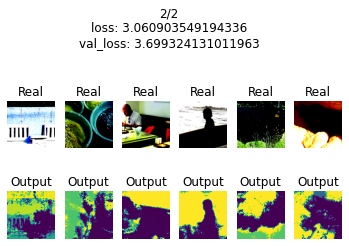

In [ ]:
model_dice = UNetWithResNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()

max_epochs = 2
optim = torch.optim.AdamW(model_dice.parameters(), lr=0.5*1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
epoch, losses = load_model(model_dice, optim, 'U-net with CrossEntropy loss_125')
losses, val_losses = train(model_dice, optim, criterion, max_epochs, train_loader, test_loader, scheduler=scheduler, name='U-net with CrossEntropy loss')

# Результаты

Загрузим результаты на последней эпохе:

In [ ]:
epoch, losses = load_model(model_dice, optim, 'U-net with CrossEntropy loss_125')

Выведем лоссы за время обучения:

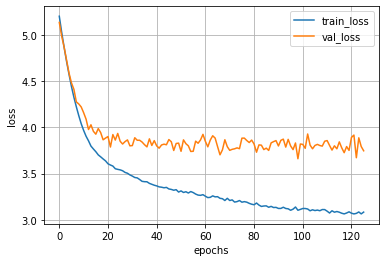

In [ ]:
plot_loss((losses[0], losses[1]))

In [ ]:
scores = (test(model_dice, test_loader, dice_coef), test(model_dice, test_loader, mse_loss))

In [ ]:
print("Results for U-Net with ResNet blocks: ")
print("Dice coef: ", scores[0])
print("MSE loss: ", scores[1])

Results for U-Net with ResNet blocks: 
Dice coef:  74.66403198242188
MSE loss:  5880.8056640625


Обучим теперь аналогичную модель, но только с MobileNet блоками

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


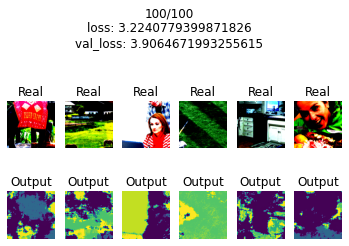

In [ ]:
model_mobile = UNetWithMobileNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()

max_epochs = 100
optim = torch.optim.AdamW(model_mobile.parameters(), lr=0.5*1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', cooldown=5, factor=0.5, patience=15)
losses, val_losses = train(model_mobile, optim, criterion, max_epochs, train_loader, test_loader, scheduler=scheduler, name='Mobile U-net')

Основное преемущество данного варианта сети - скорость обучения. Получаем выйгрыш во времени примерно в два раза, при этом качество не сильно отличается от предыдущего варианта. Строим графики:

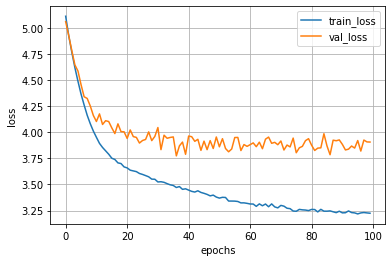

In [ ]:
plot_loss((losses, val_losses))

Посчитаем результаты:

In [ ]:
scores = (test(model_mobile, test_loader, dice_coef), test(model_mobile, test_loader, mse_loss))

In [ ]:
print("Results for U-Net with MobileNet blocks: ")
print("Dice coef: ", scores[0])
print("MSE loss: ", scores[1])

Results for U-Net with MobileNet blocks: 
Dice coef:  74.94223022460938
MSE loss:  6043.10009765625


Загрузим предобученную сеть с ResNet блоками для работы с этим датасетом

# Предобученная сеть

In [ ]:
import torch.hub
model = torch.hub.load("kazuto1011/deeplab-pytorch", "deeplabv2_resnet101", pretrained='cocostuff164k', n_classes=182)

Using cache found in /root/.cache/torch/hub/kazuto1011_deeplab-pytorch_master


In [ ]:
model.to(DEVICE)

MSC(
  (base): DeepLabV2(
    (layer1): _Stem(
      (conv1): _ConvBnReLU(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.0010000000000000009, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
    )
    (layer2): _ResLayer(
      (block1): _Bottleneck(
        (reduce): _ConvBnReLU(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.0010000000000000009, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (conv3x3): _ConvBnReLU(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.0010000000000000009, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
    

In [ ]:
import torch.nn.functional as F

In [ ]:
def test_pretrained(model, data_val, loss_fn):
  avg_val_loss = 0
  model.eval()
  for X_batch, Y_batch in data_val:
      with torch.no_grad():
        # to device
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)

        # forward
        Y_pred =  F.softmax(F.interpolate(model(X_batch).to(DEVICE), size=(RESCALE_SIZE, RESCALE_SIZE), mode="bilinear", align_corners=False), dim=1)

        val_loss = loss_fn(Y_pred, Y_batch) # forward-pass

        # calculate loss to show the user
        avg_val_loss += val_loss / len(data_val)
  return avg_val_loss.item()

In [ ]:
scores = (test_pretrained(model, test_loader, dice_coef), test_pretrained(model, test_loader, mse_loss))

In [ ]:
print("Results for deeplabv3_resnet101: ")
print("Dice coef: ", scores[0])
print("MSE loss: ", scores[1])

Results for deeplabv3_resnet101: 
Dice coef:  95.99269104003906
MSE loss:  22508.291015625


In [ ]:
X_val, Y_val = next(iter(test_loader))

# show intermediate results
model.eval()  # testing mode

Y_pred = F.interpolate(model(X_val.to(DEVICE)), size=(RESCALE_SIZE, RESCALE_SIZE), mode="bilinear", align_corners=False)

Y_hat = torch.argmax(F.softmax(Y_pred, dim=1), dim=1, keepdim=True).cpu().detach().numpy() # detach and put into cpu

# Visualize tools
for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(Y_hat[k, 0])
    plt.title('Output')
    plt.axis('off')
plt.subplots_adjust(top=0.7)
plt.show()

Результаты у предобученной не очень, однако Dice coef выше. Возможно, это происходит из-за ошибок при интерполяции, так как изображение на выходе имеет размер 29 на 29. Сеть из torchvision хоть и имеет всего 21 класс, но гораздо лучше сегментирует изображения. Также хорошо себя показала сеть с MobileNet блоками, очень быстро учится и выдает хорошие результаты - нехуже ResNet/